# Asana Take-Home Challenge
## Finding Adopted Users

The purpose of this challenge is to identify the features that best predict the engagement level of users. An **adopted user** is one that has logged in at least 3 times in at least one 7-day period. Naturally, we must then identify all adopted users. 

Below we have the dataset **users** (with a few extra columns that I evaluated).

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv', encoding = "ISO-8859-1")
user_engagement_df['date'] = user_engagement_df.time_stamp.apply(lambda x: x[:10])
first_day = user_engagement_df.date.min()
user_engagement_df['day'] = user_engagement_df.date\
    .apply(lambda x: (pd.to_datetime(x) - pd.to_datetime(first_day)).days)
user_engagement_df.head()

,time_stamp,user_id,visited,date,day
0,2014-04-22 03:53:30,1,1,2014-04-22,691
1,2013-11-15 03:45:04,2,1,2013-11-15,533
2,2013-11-29 03:45:04,2,1,2013-11-29,547
3,2013-12-09 03:45:04,2,1,2013-12-09,557
4,2013-12-25 03:45:04,2,1,2013-12-25,573


In the above table, I converted the time_stamp column to a day column, where 0 represents the minimum date found in the DataFrame. Next we will use the day column to evaluate the engagement-level of users. (1 for adopted user & 0 otherwise)

In [3]:
user_engagement_df = user_engagement_df[['user_id','day']]
user_engagement_df = user_engagement_df.sort_values(['user_id','day'])
adopted_users = set()
for i in range(len(user_engagement_df) - 2):
    if user_engagement_df.user_id[i] == user_engagement_df.user_id[i + 1] and \
        user_engagement_df.user_id[i + 1] == user_engagement_df.user_id[i + 2]:
            if user_engagement_df.day[i + 2] - user_engagement_df.day[i] < 7:
                adopted_users.add(user_engagement_df.user_id[i])

In [4]:
user_engagement_df = user_engagement_df.groupby('user_id').count().reset_index()
user_engagement_df['adopted user'] = user_engagement_df.user_id\
    .apply(lambda x: 1 if x in adopted_users else 0)
user_engagement_df = user_engagement_df[['user_id', 'adopted user']]
user_engagement_df.head()

,user_id,adopted user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


We now have a table that shows us if a user is an adopted user!

## Fitting Prediction Model

Our next step is to fit a prediction model in order to predict the values of the adopted users table above. I have chosen to use the XGBoost model. 

Some highlights:

1. I have seen XGBoost used to win many Kaggle competitions so it has proven to be a powerful tool for predicting real-world data. 
2. It can handle sparse training data very well, a useful feature if we want to include categorical data.
3. Most importantly, since our goal is to find the most important features in predicting adopted users, XGBoost provides an easy-to-use package for visualizing the relative importance of features in our final traned model. 

### Cleaning Training Data/Feature Extraction

Below we have the untouched training data:

In [5]:
users_df = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


#### Days Alive

First, we see that there is a "creation time" (which is in datetime timestamp form) and "last login" (which is in unix timestamp form). If we convert both columns to datetimes, then we can find the difference for our first feature: days alive. I would think that the longer the time between account creation and last login, the higher likelihood that the given user is an adopted user. 

**However, since we have to predict future adoption, we cannot use days_alive because we do not know last_session_creation_time when a new user signs up**

#### Email Domain

Obviously, email addresses are unique for each user, but I noticed that there are 7 dominant domain names: {'gmail', 'yahoo', 'jourrapide', 'cuvo', 'gustr','hotmail'} Perhaps this would be an interesting feature to explore. Here we will have 7 new columns: 1 for each common domain, and 1 for "not_common".

In [6]:
domains = ['gmail', 'yahoo', 'jourrapide', 'cuvo', 'gustr', 'hotmail']
users_df['email_domain'] = users_df.email\
    .apply(lambda x: x[x.index('@') + 1:-4] \
           if x[x.index('@') + 1:-4] in domains else 'other')
email_features = pd.get_dummies(users_df['email_domain'])
users_df = pd.concat([users_df, email_features], axis=1)

#### Creation Source
This is an easy one. Since this takes 1 of 5 values, we simply create a feature for each value:

In [7]:
creation_source_features = pd.get_dummies(users_df.creation_source)
users_df = pd.concat([users_df, creation_source_features], axis=1)

#### Email List/Marketing Drip
These two columns are already perfect for training so we don't need to do anything for these.

#### Organziation ID
This feature is a bit tricky. Each organization is represented by an integer, but the relative values of the integers mean nothing, which means we would have way too many features if we tried to dummy this. However we could group by the orgization number and then convert the organization to the number of people who use Asana within the organization. That way we can stil use this valuable information. Perhaps we can revisit making features for every organization later on, but for now I will only use organization size.

In [8]:
org_size = users_df.groupby('org_id').count().sort_values('email', ascending=False).object_id
users_df['organzation_size'] = users_df.org_id.apply(lambda x: org_size[x])

#### Invited By User ID
For invitation user id, I think the important information is **if** a user was invited by someone, not who the person is. This makes the feature extraction much easier (1's and 0's). 

In [10]:
import math
users_df['was_invited'] = users_df.invited_by_user_id\
    .apply(lambda x: 0 if math.isnan(x) else 1)

#### Review Of Extracted Features
Below I will put the finishing touches on our training data, almost done! In this step I noticed that we have user data for users with no engagement data, so I took them out of the training sample. 

In [11]:
users_df = users_df.drop(['creation_time',
                          'name', 
                          'email', 
                          'creation_source',
                          'last_session_creation_time',
                          'org_id', 
                          'invited_by_user_id',
                          'email_domain'], 1)

In [13]:
users_df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,cuvo,gmail,gustr,hotmail,jourrapide,other,yahoo,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,organzation_size,was_invited
0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,75,1
1,2,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,233,1
2,3,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,32,1
3,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,233,1
4,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,16,1


In [14]:
temp = user_engagement_df.set_index('user_id')
user_engagement_series = pd.Series(temp['adopted user'], index=temp.index)
engagement_data_users = set(user_engagement_series.index)
users_df_complete = users_df[users_df.object_id.isin(engagement_data_users)]

users_df_complete['is_adopted_user'] = users_df_complete.object_id\
    .apply(lambda x: user_engagement_series[x])
users_df_complete = users_df_complete.drop('object_id',1)
users_df_complete.head()

/Users/edwardcai/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,opted_in_to_mailing_list,enabled_for_marketing_drip,cuvo,gmail,gustr,hotmail,jourrapide,other,yahoo,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,organzation_size,was_invited,is_adopted_user
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,75,1,0
1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,233,1,1
2,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,32,1,0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,233,1,0
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,16,1,0


### Finding Most Important Features

Here we are finally able to see the importance of each feature. One of the reasons that I chose XGBoost is because it allows us to easilly plot the most important features. 

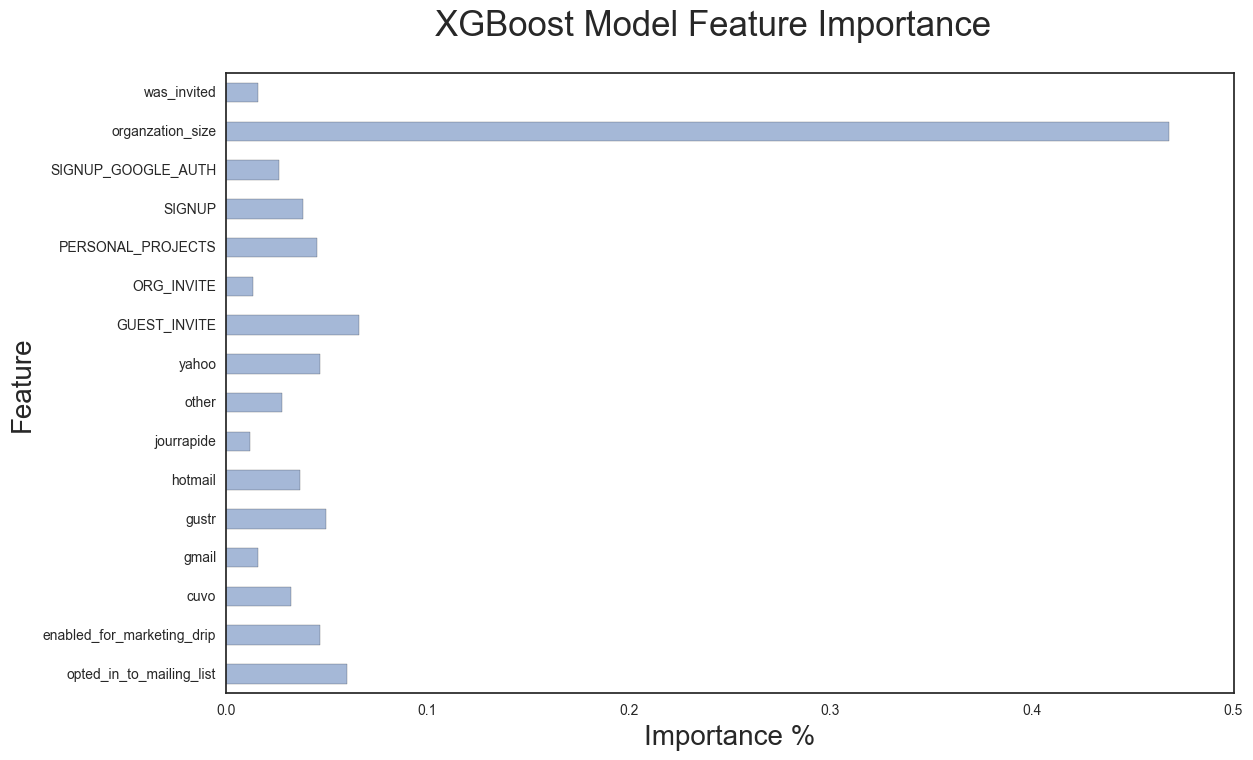

In [20]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
model = XGBClassifier()
model.fit(X, Y)

importance_series = pd.Series(model.feature_importances_, \
                              index=users_df_complete.columns[:-1])

fig = plt.figure(figsize=(13, 8))
fig.suptitle('XGBoost Model Feature Importance', fontsize=25)
plt.xlabel("Importance %", fontsize=20)
plt.ylabel("Feature", fontsize=20)
importance_series.plot(kind='barh', alpha = 0.5)

## Conclusions
#### Most Important Features: 1. organization_size 2. guest_invite 3. mailing_list 
After a lengthy data-cleaning process, we were able to quickly run a model and find our feature importance! The three most important features were as follows:

1. organization size: this is by far our most important feature. It seems that the larger organizations have a higher Asana adoption rate. This makes sense because Asana is a project management tool that becomes more useful as teams/companies grow larger. 
2. guest invite: this makes sense because guest invitations normally occur when someone is invited to join a project, which would probably mean the new guest is already committed to using the Asana platorm. 
3. opting into mailing list: this also makes sense because you would think that users who opt in for the mailing list have a higher starting affinity toward Asana. That, and the additinal emails that they receive from Asana should be a good reminder to go back on the app to check on tasks. 

That's it! Hope you enjoyed reading my take-home challenge!